# 精炼检测v1--用分类模型对所有疑似SWD的object进一步筛选

In [ ]:
version = "v1"
run_type = "pose_and_det"  # "pose_and_det" or "cls"

# 需要运行的step列表
steps_to_run = [
    # "run_clean_and_slice_images_on_dirs",           # Step 1 清理坏图并切片大图到640*640小图
    # "process_sliced_images_with_yolo_seg",          # Step 2 使用YOLO-seg模型处理640*640切片图像
    # "combine_sliced_predictions",                   # Step 3 合并seg预测结果，回到原图。 同时切出objects小图
    "run_classificationModel_on_cropped_objects",   # Step 4 使用cls模型对裁剪出的objects小图进行分类
    "filter_and_organize_predictions"               # Step 5 根据cls结果，过滤错误objects数据.
]

In [ ]:
def free_gpu():
    import gc, torch
    gc.collect()                    # 触发 Python 垃圾回收
    torch.cuda.empty_cache()        # 释放未使用的 GPU 缓存到驱动
    torch.cuda.ipc_collect()        # 清理跨进程缓存（偶尔有用）


# Step_0 查看根目录下需要运行的文件夹 
选择含有 raw_data 图片的 *_data 目录

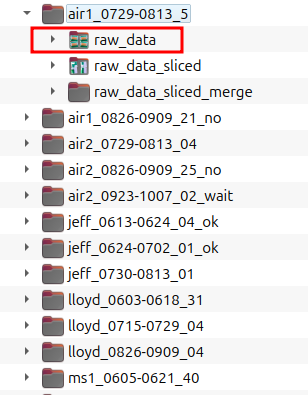


In [11]:
# 选择数据目录的核心代码
from pathlib import Path

def select_data_dirs(root_dir: Path, end_with: str = "_data"):
    # === 1) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("*/*" + end_with))

    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        return []

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 2) 让用户选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs

    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

    # === 3) 筛选掉没有 raw_data 图片的目录 ===
    chosen_dirs = [
        d for d in chosen_dirs
        if (d.parent / "raw_data").exists() and any((d.parent / "raw_data").glob("*.jpg"))
    ]

    if not chosen_dirs:
        print(f"没有找到包含图片的 *{end_with} 目录")
        return []

    return chosen_dirs

In [12]:
root_dir = Path("/workspace/models/SAHI/run_v8")
chosen_dirs = select_data_dirs(root_dir, end_with="_data")
print("最终确认的目录：", chosen_dirs)
if not chosen_dirs:
    raise ValueError("没有选择任何目录，程序终止。")

找到以下 _data 数据集：
[0] /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
将处理以下 _data 目录：
- 1. /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
最终确认的目录： [PosixPath('/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data')]


# Step_4 0301 跑分类模型

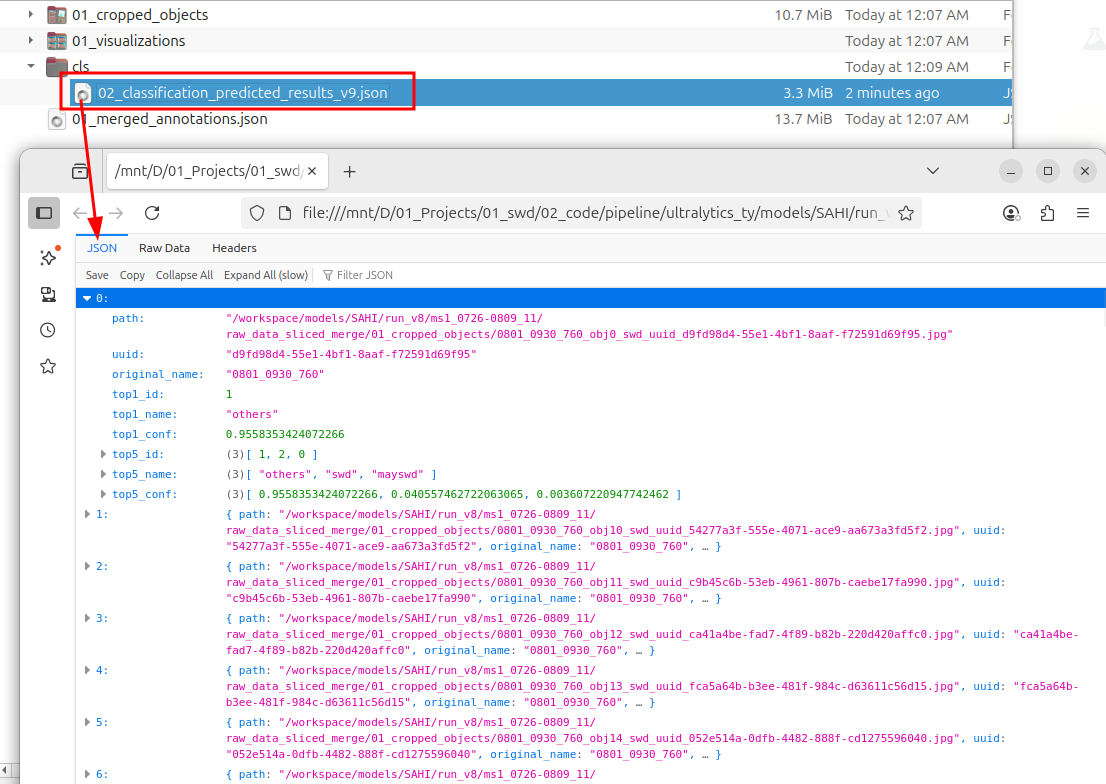

In [13]:
# Step 4 使用YOLO分类模型对裁剪目标进行分类
from pathlib import Path
from collections import Counter
from typing import List, Dict, Any, Optional
import os, re, json
from ultralytics import YOLO

# === 你已有的常量/工具 ===
UUID_RE = re.compile(r"uuid_([a-f0-9\-]+)\.jpg", re.IGNORECASE)
ORIG_RE = re.compile(r"^(\d+_\d+_\d+)_obj", re.IGNORECASE)

def get_probs_fields(res, name_map):
    """安全获取 top1/top5 字段（缺失时给空值/空列表）。"""
    probs = getattr(res, "probs", None)
    if probs is None:
        return None, None, None, [], [], []

    # top1
    try:
        top1_id = int(probs.top1)
    except Exception:
        top1_id = None
    top1_name = name_map.get(top1_id) if top1_id is not None else None

    # top1 conf
    try:
        top1_conf = float(getattr(probs.top1conf, "item", lambda: probs.top1conf)())
    except Exception:
        top1_conf = None

    # top5
    try:
        top5_id = [int(x) for x in list(probs.top5)]
    except Exception:
        top5_id = []
    top5_name = [name_map.get(i, str(i)) for i in top5_id]
    try:
        top5_conf = [float(x) for x in list(probs.top5conf)]
    except Exception:
        top5_conf = []

    return top1_id, top1_name, top1_conf, top5_id, top5_name, top5_conf


# === 封装函数：分类 cropped_objects 并保存 JSON + 返回统计 ===
def run_classificationModel_on_cropped_objects(
    dirs: List[Path],
    *,
    model_path: str,
    batch: int = 16,
    version: str,
    save_per_dir_json: bool = True
) -> Dict[str, Dict[str, Any]]:
    """
    对每个目录 d 的 `d_sliced_merge/cropped_objects/` 进行分类，
    生成 `d_sliced_merge/classification_predicted_results_{version}.json`，
    并返回每个目录的统计信息（按类别计数、总数、输出路径等）。
    """
    # 1) 只加载一次模型
    print(f"加载分类模型：{model_path}")
    model = YOLO(model_path)
    class_names = model.names  # dict: {0: name, ...}

    summary: Dict[str, Dict[str, Any]] = {}

    for d in dirs:
        print(f"\n=== 处理目录: {d} ===")
        input_dir   = str(d) + "_sliced_merge/01_cropped_objects/"
        output_json = str(d) + f"_sliced_merge/cls_{version}/02_classification_predicted_results.json"

        # 1) 创建输出目录
        os.makedirs(os.path.dirname(output_json), exist_ok=True)

        # 2) 检查输入目录是否有 JPG
        jpgs = list(Path(input_dir).glob("*.jpg"))
        if not jpgs:
            print(f"⚠️ 输入目录 {input_dir} 没有 JPG 文件，跳过")
            continue

        # 3) 执行预测（Ultralytics 支持传目录）
        results = model(input_dir, batch=batch, device=0)
        data = []
        counts = Counter()

        for res in results:
            path = getattr(res, "path", "")
            fname = os.path.basename(path)

            # 提取 uuid / 原图名
            uuid_match = UUID_RE.search(fname)
            uuid_str = uuid_match.group(1) if uuid_match else None
            orig_match = ORIG_RE.match(fname)
            original_name = orig_match.group(1) if orig_match else None

            # 概率字段
            top1_id, top1_name, top1_conf, top5_id, top5_name, top5_conf = get_probs_fields(res, class_names)
            if top1_id is not None:
                counts[top1_id] += 1

            # 记录
            data.append({
                "path": path,
                "uuid": uuid_str,
                "original_name": original_name,
                "top1_id": top1_id,
                "top1_name": top1_name,
                "top1_conf": top1_conf,
                "top5_id": top5_id,
                "top5_name": top5_name,
                "top5_conf": top5_conf,
            })

        # 4) 打印并汇总统计
        print("分类统计结果：")
        for cls_id, num in counts.items():
            print(f"{class_names.get(cls_id, cls_id)}: {num}")
        total = sum(counts.values())
        print(f"总计: {total}")

        if save_per_dir_json:
            with open(output_json, "w", encoding="utf-8") as f:
                json.dump(data, f, indent=2, ensure_ascii=False)
            print(f"✅ 已保存到 {output_json}")

        # 5) 写入 summary
        summary[str(d)] = {
            "input_dir": input_dir,
            "output_json": output_json if save_per_dir_json else None,
            "total": total,
            "per_class": {class_names.get(k, str(k)): v for k, v in counts.items()},
        }

    print("\n✅ 分类任务完成。")
    return summary

In [ ]:
if "run_classificationModel_on_cropped_objects" in steps_to_run:
    cls_model_path = "/workspace/models/best_model/yolo11n-cls-best_v5.pt"
    # cls_model_path = "/workspace/models/runs_yolov11_cls/output1/yolo11s-cls.pt/data_split_0.6_0.2_0.2_16----x/weights/best.pt"
    summary = run_classificationModel_on_cropped_objects(
        chosen_dirs,
        model_path=cls_model_path,
        batch=128,
        version=version,
        save_per_dir_json=True
    )
    print("处理统计：", summary)
    free_gpu()
else:
    print("跳过 Step 4: 对裁剪对象进行分类")

加载分类模型：/workspace/models/best_model/yolo11n-cls-best_v5.pt

=== 处理目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data ===

image 1/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj0_swd_uuid_d9fd98d4-55e1-4bf1-8aaf-f72591d69f95.jpg: 64x64 others 0.96, swd 0.04, mayswd 0.00, 0.0ms
image 2/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj10_swd_uuid_54277a3f-555e-4071-ace9-aa673a3fd5f2.jpg: 64x64 others 0.92, swd 0.06, mayswd 0.02, 0.0ms
image 3/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj11_swd_uuid_c9b45c6b-53eb-4961-807b-caebe17fa990.jpg: 64x64 others 0.78, swd 0.21, mayswd 0.01, 0.0ms
image 4/5900 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/0801_0930_760_obj12_swd_uuid_ca41a4be-fad7-4f89-b82b-220d420affc0.jpg: 64x64 others 0.82, swd 0.17, mayswd 0.

# Step_5 0302 根据分类结果，过滤错误数据

### 输入
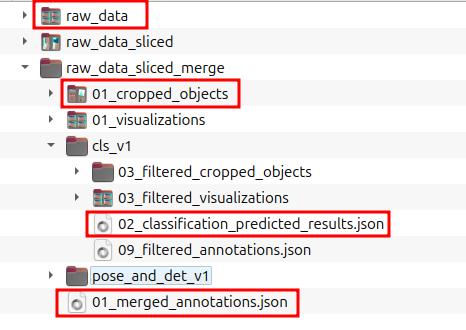
### 输出
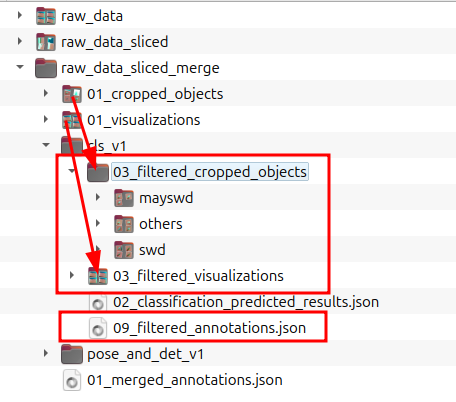
### 效果
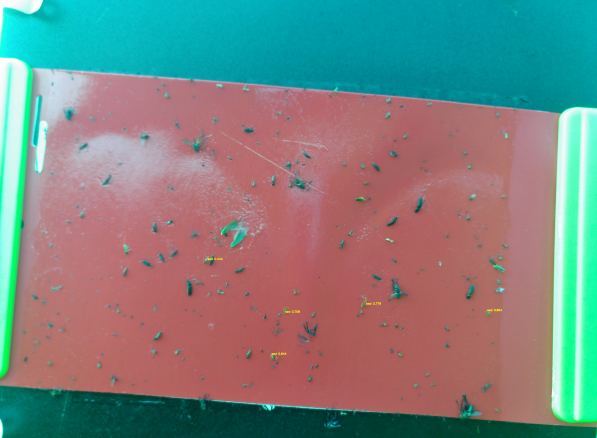
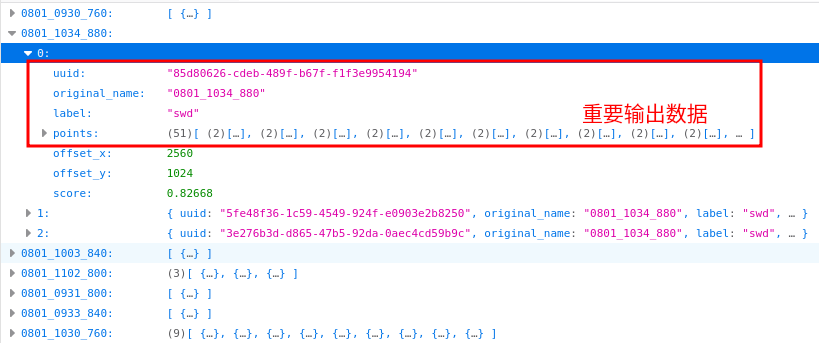

In [15]:
# Step 5 根据分类结果筛选和组织预测结果核心代码

import os
import re
import shutil
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import cv2
import numpy as np
import orjson
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from tqdm import tqdm
from collections import Counter

# ========= 可视化常量 =========
LINE_COLOR_BGR = (0, 255, 255)
LINE_WIDTH = 1
TEXT_SCALE = 0.7
TEXT_THICKNESS = 2
TEXT_COLOR_BGR = (0, 255, 255)
TEXT_FONT = cv2.FONT_HERSHEY_SIMPLEX
TEXT_VERTICAL_SPACING = 18


# ========= JSON 工具函数 =========
def load_json_file(file_path: Path):
    """加载JSON文件"""
    with file_path.open("rb") as f:
        return orjson.loads(f.read())

def save_json_to_file(data, file_path: Path):
    """保存数据到JSON文件"""
    file_path.parent.mkdir(parents=True, exist_ok=True)
    with file_path.open("wb") as f:
        f.write(orjson.dumps(data))

# ========= 工具函数 =========
def load_classification_results(classification_file_path: Path) -> Dict[str, Dict]:
    """
    读取分类结果，返回 uuid -> 分类项 的映射
    
    支持两种JSON结构：
    1) {"results": [...]}
    2) [ ... ]
    """
    data = load_json_file(classification_file_path)
    if isinstance(data, dict) and "results" in data:
        items = data["results"]
    elif isinstance(data, list):
        items = data
    else:
        raise ValueError("分类结果JSON文件结构不支持")
    return {item["uuid"]: item for item in items if "uuid" in item}

def build_image_path_index(image_directory: Path) -> Dict[str, Path]:
    """建立图像文件名到路径的索引"""
    index: Dict[str, Path] = {}
    for extension in ("*.jpg", "*.jpeg", "*.png"):
        for image_path in image_directory.glob(extension):
            index[image_path.stem] = image_path
    return index

def filter_and_relabel_annotations(
    merged_annotations: Dict[str, List[dict]],
    classification_map: Dict[str, dict],
    keep_classes: Optional[List[str]],
    drop_classes: Optional[List[str]],
    relabel_with_prediction: bool
) -> Tuple[Dict[str, List[dict]], Tuple[int, int, int]]:
    """
    根据分类结果筛选和重标注
    
    Returns:
        Tuple[过滤后的标注, (保留数量, 丢弃数量, 未找到数量)]
    """
    filtered_annotations: Dict[str, List[dict]] = {}
    kept_count = dropped_count = not_found_count = 0
    keep_classes_set = set(keep_classes) if keep_classes else None
    drop_classes_set = set(drop_classes) if drop_classes else None

    for image_name, annotations in tqdm(merged_annotations.items(), desc="筛选标注", ncols=80):
        filtered_image_annotations: List[dict] = []
        for annotation in annotations:
            uuid = annotation.get("uuid")
            if not uuid:
                continue
                
            classification_result = classification_map.get(uuid)
            if classification_result is None:
                not_found_count += 1
                continue

            predicted_class = classification_result.get("top1_name")
            # 应用筛选规则
            if keep_classes_set is not None and predicted_class not in keep_classes_set:
                dropped_count += 1
                continue
            if drop_classes_set is not None and predicted_class in drop_classes_set:
                dropped_count += 1
                continue

            # 重标注或保留原标注
            if relabel_with_prediction and predicted_class:
                new_annotation = dict(annotation)
                new_annotation["label"] = predicted_class
                filtered_image_annotations.append(new_annotation)
            else:
                filtered_image_annotations.append(annotation)
            kept_count += 1

        if filtered_image_annotations:
            filtered_annotations[image_name] = filtered_image_annotations

    return filtered_annotations, (kept_count, dropped_count, not_found_count)

# ========= 可视化函数 =========

def _visualize_single_image(image_name: str, annotations: List[dict], image_path_index: Dict[str, str], output_directory: str):
    """可视化单张图像的标注"""
    image_path = image_path_index.get(image_name) or image_path_index.get(Path(image_name).stem)
    if not image_path:
        return None
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        return None

    for annotation_index, annotation in enumerate(annotations):
        points = annotation["points"]
        points_array = np.asarray(points, dtype=np.int32).reshape(-1, 1, 2)
        cv2.polylines(image, [points_array], True, LINE_COLOR_BGR, LINE_WIDTH)

        label = str(annotation.get("label", ""))
        score = annotation.get("score")
        label_text = f"{label} {score:.3f}" if isinstance(score, (float, int)) else label
        x0, y0 = int(points[0][0]), int(points[0][1])
        cv2.putText(image, label_text, (x0 + 6, y0 + 6 + (annotation_index % 3) * TEXT_VERTICAL_SPACING),
                    TEXT_FONT, TEXT_SCALE, TEXT_COLOR_BGR, TEXT_THICKNESS, cv2.LINE_AA)

    output_path = str(Path(output_directory) / f"{Path(image_name).stem}_visualized.jpg")
    cv2.imwrite(output_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    return output_path

def visualize_annotations_parallel(annotations: Dict[str, List[dict]], original_image_directory: Path, output_directory: Path, max_workers: int):
    """并行可视化所有标注"""
    output_directory.mkdir(parents=True, exist_ok=True)
    image_path_index = {name: str(path) for name, path in build_image_path_index(original_image_directory).items()}
    total_images = len(annotations)
    if total_images == 0:
        return
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(_visualize_single_image, image_name, image_annotations, image_path_index, str(output_directory))
            for image_name, image_annotations in annotations.items()
        ]
        for _ in tqdm(as_completed(futures), total=total_images, desc="可视化处理", ncols=80):
            pass

# ========= 裁剪对象分类整理 =========
UUID_PATTERN = re.compile(r"uuid_([a-f0-9\-]+)\.(jpg|jpeg|png)$", re.IGNORECASE)

def organize_cropped_objects_by_class(
    cropped_objects_directory: Path,
    output_root_directory: Path,
    classification_map: Dict[str, dict],
    keep_classes: Optional[List[str]],
    drop_classes: Optional[List[str]],
    max_workers: int
) -> Tuple[int, int, int, int, Counter]:
    """
    将裁剪对象按分类结果整理到对应类别目录
    
    Returns:
        Tuple[总文件数, 符合条件数量, 无预测数量, 其他数量, 类别计数]
    """
    if not cropped_objects_directory.exists():
        print(f"⚠️ 未找到裁剪目录: {cropped_objects_directory}")
        return 0, 0, 0, 0, Counter()

    image_files: List[Path] = []
    for extension in ("*.jpg", "*.jpeg", "*.png"):
        image_files.extend(cropped_objects_directory.glob(extension))
    total_files = len(image_files)
    if total_files == 0:
        print(f"⚠️ 裁剪目录为空: {cropped_objects_directory}")
        return 0, 0, 0, 0, Counter()

    kept_count = 0
    no_prediction_count = 0
    others_count = 0
    class_counter = Counter()
    keep_classes_set = set(keep_classes) if keep_classes else None
    drop_classes_set = set(drop_classes) if drop_classes else None

    def ensure_directory_exists(directory: Path):
        directory.mkdir(parents=True, exist_ok=True)
        return directory

    def process_single_image(image_path: Path):
        nonlocal kept_count, no_prediction_count, others_count
        uuid_match = UUID_PATTERN.search(image_path.name)
        if not uuid_match:
            # 文件名不符合规则 → others
            destination_directory = ensure_directory_exists(output_root_directory / "others")
            shutil.copy2(image_path, destination_directory / image_path.name)
            class_counter.update(["others"])
            others_count += 1
            return

        uuid = uuid_match.group(1)
        classification_result = classification_map.get(uuid)
        if classification_result is None:
            # 无预测结果 → others
            destination_directory = ensure_directory_exists(output_root_directory / "others")
            shutil.copy2(image_path, destination_directory / image_path.name)
            class_counter.update(["others"])
            others_count += 1
            no_prediction_count += 1
            return

        predicted_class = classification_result.get("top1_name")
        # 应用筛选规则
        if keep_classes_set is not None and predicted_class not in keep_classes_set:
            destination_directory = ensure_directory_exists(output_root_directory / "others")
            shutil.copy2(image_path, destination_directory / image_path.name)
            class_counter.update(["others"])
            others_count += 1
            return
        if drop_classes_set is not None and predicted_class in drop_classes_set:
            destination_directory = ensure_directory_exists(output_root_directory / "others")
            shutil.copy2(image_path, destination_directory / image_path.name)
            class_counter.update(["others"])
            others_count += 1
            return

        # ✅ 符合条件，复制到对应类别目录
        class_subdirectory = predicted_class or "unknown"
        destination_directory = ensure_directory_exists(output_root_directory / class_subdirectory)
        shutil.copy2(image_path, destination_directory / image_path.name)
        class_counter.update([class_subdirectory])
        kept_count += 1

    output_root_directory.mkdir(parents=True, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(process_single_image, image_files), total=total_files, desc="整理裁剪对象", ncols=80))

    return total_files, kept_count, no_prediction_count, others_count, class_counter




In [ ]:
def filter_and_organize_predictions(chosen_directories, version):
    """
    主函数：根据分类结果筛选和组织预测结果
    """
    # ---- 过滤策略配置 ----
    CLASSES_TO_DROP: Optional[List[str]] = None
    CLASSES_TO_KEEP: Optional[List[str]] = ["swd", "mayswd"]
    RELABEL_WITH_PREDICTION: bool = True

    # ---- 功能开关与并发设置 ----
    ENABLE_VISUALIZATION = True
    ENABLE_OBJECT_ORGANIZATION = True
    MAX_WORKERS = min(max(1, (os.cpu_count() or 2) - 1), 8)

    for directory in chosen_directories:
        print(f"\n=== 处理目录: {directory} ===")   
        
        # ---- 路径配置 ----
        # 输入
        original_images_directory = directory.parent / directory.name
        cropped_objects_directory = directory.parent / (directory.name + "_sliced_merge") / "01_cropped_objects"
        merged_annotations_json_path = directory.parent / (directory.name + "_sliced_merge") / "01_merged_annotations.json"
        classification_json_path = directory.parent / (directory.name + "_sliced_merge") / f"cls_{version}" / f"02_classification_predicted_results.json"
        # 输出
        filtered_annotations_json_path = directory.parent / (directory.name + "_sliced_merge") / f"cls_{version}" / f"09_filtered_annotations.json"
        visualization_output_directory = directory.parent / (directory.name + "_sliced_merge") / f"cls_{version}" / f"03_filtered_visualizations"
        filtered_cropped_output_directory = directory.parent / (directory.name + "_sliced_merge") / f"cls_{version}" / f"03_filtered_cropped_objects"

        # 检查原图目录是否存在
        if not any(original_images_directory.glob("*.jpg")):
            print(f"⚠️ 跳过，原图目录不存在或无图片: {original_images_directory}")
            continue

        # 读取分类结果和合并标注
        classification_map = load_classification_results(classification_json_path)
        merged_annotations = load_json_file(merged_annotations_json_path)

        # 筛选和重标注
        filtered_annotations, (kept_count, dropped_count, not_found_count) = filter_and_relabel_annotations(
            merged_annotations=merged_annotations,
            classification_map=classification_map,
            keep_classes=CLASSES_TO_KEEP,
            drop_classes=CLASSES_TO_DROP,
            relabel_with_prediction=RELABEL_WITH_PREDICTION
        )
        print(f"\n[标注筛选统计] 保留: {kept_count}, 丢弃: {dropped_count}, 未找到预测: {not_found_count}")

        save_json_to_file(filtered_annotations, filtered_annotations_json_path)
        print(f"✅ 已保存筛选后的标注: {filtered_annotations_json_path}")

        # 可视化处理
        if ENABLE_VISUALIZATION:
            visualize_annotations_parallel(filtered_annotations, original_images_directory, visualization_output_directory, max_workers=MAX_WORKERS)
            print(f"✅ 已保存可视化结果: {visualization_output_directory}")

        # 裁剪对象分类整理
        if ENABLE_OBJECT_ORGANIZATION:
            total_files, kept_files, no_prediction_files, others_files, class_distribution = organize_cropped_objects_by_class(
                cropped_objects_directory,
                filtered_cropped_output_directory,
                classification_map=classification_map,
                keep_classes=CLASSES_TO_KEEP,
                drop_classes=CLASSES_TO_DROP,
                max_workers=MAX_WORKERS
            )
            print("\n[裁剪对象整理统计]")
            print(f"  总文件数: {total_files}")
            print(f"  符合规则并归类: {kept_files}")
            print(f"  无预测放入others: {no_prediction_files}")
            print(f"  其他原因放入others: {others_files - no_prediction_files}")
            if class_distribution:
                print("  各类别数量分布：")
                for class_name, count in class_distribution.most_common():
                    print(f"    {class_name}: {count}")
            print(f"✅ 已分类保存到: {filtered_cropped_output_directory}")

In [17]:
if "filter_and_organize_predictions" in steps_to_run:
    filter_and_organize_predictions(chosen_dirs, version=version)
else:
    print("跳过 Step 5: 根据分类结果筛选和组织预测结果")


=== 处理目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data ===


筛选标注: 100%|██████████████████████████████| 87/87 [00:00<00:00, 37642.30it/s]


[标注筛选统计] 保留: 233, 丢弃: 5667, 未找到预测: 0
✅ 已保存筛选后的标注: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/cls_v1/03_filtered_annotations.json



可视化处理: 100%|███████████████████████████████| 71/71 [00:01<00:00, 66.07it/s]


✅ 已保存可视化结果: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/cls_v1/03_filtered_visualizations


整理裁剪对象: 100%|████████████████████████| 5900/5900 [00:12<00:00, 477.06it/s]



[裁剪对象整理统计]
  总文件数: 5900
  符合规则并归类: 233
  无预测放入others: 0
  其他原因放入others: 5667
  各类别数量分布：
    others: 5667
    swd: 230
    mayswd: 3
✅ 已分类保存到: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/cls_v1/03_filtered_cropped_objects
